# Generación de un corpus limitado a un umbral determinado

In [25]:
def corpus(input_file, output_file, umbral = 5):
    with open(input_file, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            
    ## Con gensim no es necesario usar la función build_vocab, el constructor lo construye en base al array de palabras
    corpus_frequency = {}
    for line in lines[1:]:
        for word in line.split("\t")[0].split(" "):
            if word in corpus_frequency:
                corpus_frequency[word] += 1
                continue
            corpus_frequency[word] = 1

    # Eliminar palabras que aparezcan menos veces de la esperada
    with open(output_file, 'w', encoding='utf-8') as file:
        file.write("sinopsis\tgenero\n")
        for line in lines[1:]:
            synopsis, genre = line.split("\t")
            file.write(f"{synopsis}\t{genre}")

In [26]:
input_file = '../data/stemming_data.txt'
outpu_file = '../data/corpus_data.txt'
corpus(input_file, outpu_file)

Preparamos una sección para tokenizar las palabras de los ejemplos de prueba que se vayan probando, y así aumentar la precisión

In [27]:
# Obtener la lista de stopwords en español

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import string


stop_words = set(stopwords.words('spanish'))
special_chars = [ "''", "...", "``", "<<", ">>", '""', "”", "“"]
category_alias = {}

def word_accepted(word):
    return word.lower() not in stop_words and word[0] not in string.punctuation and word[-1] not in string.punctuation and word not in special_chars

def vectorization(model_type, model = None, corpus = None):
    
    ## Vectorizamos las palabras
    if model_type in ['CBOW','SG']:
        keywords = model.wv.index_to_key
        vector = []
        tmp = []
        print
        for text in corpus:
            for word in text:
                if word in keywords:
                    tmp += [model.wv[word]]
            vector += [tmp]
            tmp = []
                
        return vector
    elif model_type == 'BAYES':
        from sklearn.feature_extraction.text import CountVectorizer
    return CountVectorizer()


def categorize(category, inverse = 0):
    if not inverse:
        if category in category_alias:
            return category_alias[category]
        if category_alias:
            category_alias[category] = max(category_alias.values()) + 1
        else:
            category_alias[category] = 0
        return category_alias[category]
    else:
        for translation, alias in category_alias.items():
            if alias == category:
                return translation
        return "None"

def normalize(text):
    import re
    import nltk
    from nltk.tokenize import word_tokenize
    from nltk.stem import SnowballStemmer
    
    stemmer = SnowballStemmer('spanish')
    
    tokenize = []
    for s in text:
        tmp = [token.lower() for token in word_tokenize(s) if word_accepted(token) and not re.search("^\s*\d+\s*$", token) ]
        tokenize.append([stemmer.stem(token) for token in nltk.word_tokenize(' '.join(tmp))])
    return tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/moffinguer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/moffinguer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [48]:
## Display graphs comparing each word by model
def display_bar_graph(data):
    import matplotlib.pyplot as plt
    import numpy as np
    colors = ['red', 'green', 'blue', 'orange', 'purple', 'pink', 'yellow', 'brown', 'gray', 'cyan']

    fig, ax = plt.subplots()

    for i, (word, values) in enumerate(data.items()):
        labels = [x[0] for x in values]
        scores = [x[1] * 100 for x in values]
        color = colors[i % len(colors)]
        ax.scatter(scores, labels, color=color, label=word, marker = 'o')

    ax.legend()
    ax.set_ylabel('Palabra')
    ax.set_xlabel('Similitud')
    ax.set_title('Grafico de Similitud')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Función que hace el entrenamiento de las palabras del corpus
### En base a los 3 tipos de modelos con los que vamos a trabajar creamos una función genérica que los abarque

Aquellos modelos de la librería de Gensim, Bolsa de palabras y Skip Gram, son entrenados con el corpus limitado.
Al necesitar vectores de palabras, que indique características de las palabras en base a valores numéricos, ya que no puede analizar cadenas como tal, requerimos de un proceso de vectorización, de esta forma y calculando la media de cada una de las propiedades de cada palabra, obtendremos un vector unidimensional por cada una las sinopsis de las peliculas.

En el modelo de Bayes, repartimos el corpus en 2 secciones de manera que usando las facilidades de la librería de SKLearn, vectorizamos las palabras del corpus de entremiento.

In [29]:
## Load a model to train
def training(input_file, model_type='CBOW'):  
    if model_type in ['CBOW','SG']:
        
        # Obtener listado de palabras por cada pelicula de los ejemplos
        corpus = []
        topic = []
        with open(input_file, 'r', encoding='utf-8') as file:
            lines = file.readlines()
        for line in lines[1:]:
            tmp = line.split("\t")
            corpus += [tmp[0].split(" ")]
            topic += [tmp[1].strip()]
        
        from gensim.models import Word2Vec
        model = Word2Vec(sentences=corpus, sg = ( 0 if model_type == 'CBOW' else 1 ), epochs=500, seed=673721 )
        vector = vectorization(model_type, model, corpus)
        
        # Calculamos una media para normalizar y quedarnos con vectores de 5 elementos por cada ejemplo
        import numpy as np
        weight = [np.mean(np.array(weights), axis=0) for weights in vector]
        
        from sklearn.linear_model import LogisticRegression
        from sklearn.preprocessing import StandardScaler
        from sklearn.pipeline import make_pipeline
        clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
        clf.fit(weight, [categorize(theme) for theme in topic])
        return (model, weight, clf)    
    
    elif model_type == "BAYES":
        import pandas as pd 
        df = pd.read_csv(input_file, delimiter='\t')
       
        ## Convertimos cada genero a un valor numérico
        df['genero'] = df['genero'].apply( lambda c : categorize(c) )

        ## Entrenamiento, creando vectores por las palabras
        from sklearn.model_selection import train_test_split
        films_train, films_test, response_train, response_test = train_test_split( df.sinopsis, df.genero, test_size = 0.25)
         
        vector = vectorization(model_type)
        films_train_count = vector.fit_transform(films_train)
        
        from sklearn.naive_bayes import MultinomialNB
        model = MultinomialNB()
        model.fit(films_train_count, response_train)
        return (model,vector)
    
    else:
        print(f"ERROR unknown model {model}")

# Función que predice el tipo de película
### En base a los 3 tipos de modelos con los que vamos a trabajar creamos una función genérica que los abarque

La idea es similar en los 3 modelos, al tomar las sinopsis y tokenizarlas, buscamos encontrar la mayor similitud sobre cada vector y una categoría

In [30]:
def predict(synopsis, model, vector, clf ,type_model = 'CBOW', expected_output = []):
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    
    import pandas as pd 
    df = pd.read_csv(input_file, delimiter='\t')

    ## Convertimos cada genero a un valor numérico
    df['genero'] = df['genero'].apply( lambda c : categorize(c) )

    
    if type(synopsis) is str:
        synopsis = [synopsis]
   
    if type_model in ['CBOW','SG']:
        
        films_train, films_test, response_train, response_test = train_test_split( df.sinopsis, df.genero, test_size = 0.25, random_state=42)
        
        synopsis = normalize(films_test)
        temp_vector = vectorization(type_model, model, synopsis)
       
        import numpy as np
        weight = [np.mean(np.array(weights), axis=0) for weights in temp_vector]

        predictions = clf.predict(weight)
        
    elif type_model == "BAYES":
        
        films_train, films_test, response_train, response_test = train_test_split( df.sinopsis, df.genero, test_size = 0.25)
        
        synopsis = vector.transform(films_test)
        predictions = model.predict(synopsis)
        
    else:
        print(f"ERROR unknown model {type_model}")
        
    accuracy = accuracy_score(response_test, predictions)
    matrix = confusion_matrix(response_test, predictions)
    report = classification_report(response_test, predictions, zero_division=1)

    print('ACCURACY: ', accuracy)
    print('MATRIX CONFUSION: ')
    print(matrix)
    print('---------------------------------------------------------------')
    print(report)

## Testing

In [47]:
with open('../data/data.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

examples = lines[1:int(len(lines) / 2):15]
expected_output = [ theme.split("\t")[1] for theme in examples]
examples = [ synopsis.split("\t")[0] for synopsis in examples]
input_file = '../data/corpus_data.txt'


print("Usamos Bayes Multinomial")
(model,vector) = training(input_file, "BAYES")
clf = None

predict(examples, model, vector, clf, 'BAYES', expected_output)

Usamos Bayes Multinomial
ACCURACY:  0.8761061946902655
MATRIX CONFUSION: 
[[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 12  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 28  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  1  6  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  3  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0]
 [ 1  0  1  0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
-------

ACCURACY:  0.7610619469026548
MATRIX CONFUSION: 
[[ 7  2  5  0  1  0  0  0  0  0  0  0  0  0]
 [ 0 10  2  1  0  0  0  0  0  0  0  0  0  0]
 [ 1  2 30  0  0  0  0  0  0  0  1  0  0  0]
 [ 1  2  0  7  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  1 11  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  1  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  1]]
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.47      0.58        15
           1       0.62      0.77      0.69        13
           2       0.75      0.88      0.81        34
           3       0.64      0.70      

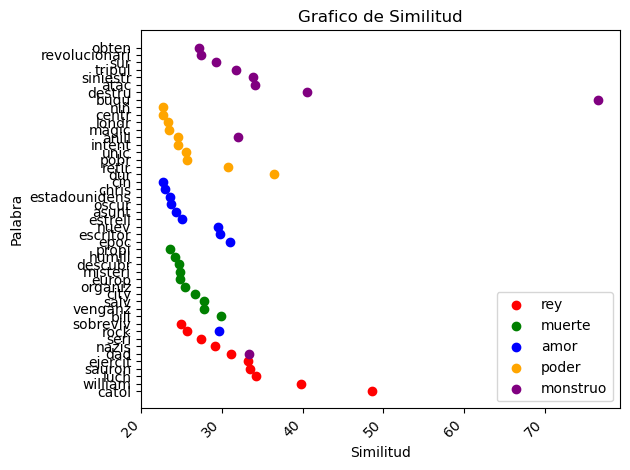

In [49]:
## Bolsa de palabras
(model, vector, clf) = training(input_file, 'CBOW')
predict(examples, model, vector, clf, 'CBOW', expected_output)

# Gráfico
data = {
    'rey': model.wv.most_similar('rey'),
    'muerte': model.wv.most_similar('muert'),
    'amor': model.wv.most_similar('amor'),
    'poder': model.wv.most_similar('pod'),
    'monstruo': model.wv.most_similar('monstru')
}
display_bar_graph(data)


Usamos SG:
ACCURACY:  0.8495575221238938
MATRIX CONFUSION: 
[[10  0  5  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 12  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  2 27  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  1  1  8  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 15  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  2]]
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.80      0.92      0.86        13
           2       0.79      0.79      0.79        34
           3       0.89     

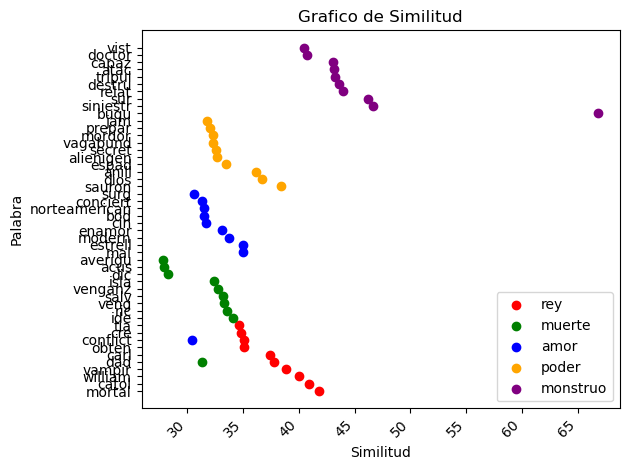

In [50]:
print("Usamos SG:")
## SG
(model, vector, clf) = training(input_file, 'SG')
predict(examples, model, vector, clf, 'SG', expected_output)

# Gráfico
data = {
    'rey': model.wv.most_similar('rey'),
    'muerte': model.wv.most_similar('muert'),
    'amor': model.wv.most_similar('amor'),
    'poder': model.wv.most_similar('pod'),
    'monstruo': model.wv.most_similar('monstru')
}
display_bar_graph(data)